In [1]:
import os
os.chdir("../../")

In [2]:
try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

In [3]:
try:
    from probml_utils import latexify,is_latexify_enabled,savefig
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify,is_latexify_enabled,savefig

In [4]:

from flax import linen as nn
from flax.core import unfreeze
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import sin_data
from models.gaussian_mlp import gmlp 
from models.mlp import mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict
import pandas as pd
# jax.config.update("jax_enable_x64", True)

In [5]:
from utilities import plot

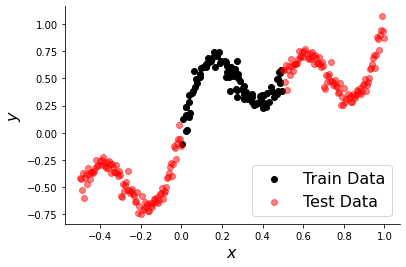

In [6]:
X, y, x_test, y_test = sin_data.load_data()
plot.plot_actualdata(X,y,x_test, y_test)

In [7]:
data = pd.DataFrame()
data['X']  = X[:,0]
data['Y'] = y[:,0]
data = data.sort_values(by='X')
X_sorted = data['X'].values.reshape(100,1)
Y_sorted = data['Y'].values.reshape(100,1)


In [8]:
data = data.sort_values(by='X')
X_sorted = data['X'].values.reshape(100,1)
Y_sorted = data['Y'].values.reshape(100,1)

In [9]:
# x_stack =jnp.concatenate([x_test_1,X_sorted,x_test_2],axis=0)
# y_stack = jnp.concatenate([y_test_1,Y_sorted,y_test_2],axis=0)

## MLP

In [10]:
mlp_model = mlp([32,32, 1],[nn.relu,nn.relu],[0,0])

In [11]:
mlp_params = mlp_model.init(jax.random.PRNGKey(0), X, True)

In [12]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [13]:
mlp_params, mlp_loss = fit(mlp_model, mlp_params, X, y, deterministic=True, 
                            batch_size=len(X), learning_rate= 0.01, epochs=2000)

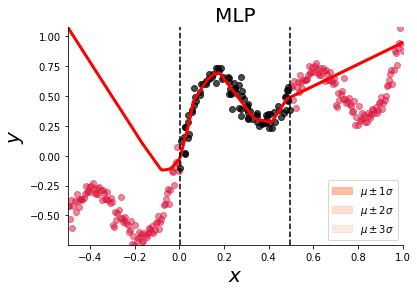

In [26]:
x_linspace = jnp.linspace(-0.5, 1, 300).reshape(-1,1)
n_points = 300
y_hat = mlp_model.apply(mlp_params, x_linspace, True)
y_hat = y_hat.reshape(n_points)
plot.plot_prediction_reg(X, y, x_test, y_test, x_linspace, y_hat, 0,'MLP')
# plt.savefig("figures/mlp_sinData",bbox_inches="tight")

In [20]:
def loss_calcc_mse(model,params,X,y,deterministic):
    y_hat= model.apply(params,X,deterministic=deterministic)
    loss = jnp.sum((y - y_hat)**2)/(2*X.shape[0])
    return loss

In [22]:
mlp_loss_test = loss_calcc_mse(mlp_model,mlp_params, x_test, y_test,deterministic=True)
mlp_loss_train = loss_calcc_mse(mlp_model,mlp_params, X, y, deterministic=True)
mlp_loss_train

DeviceArray(0.00193812, dtype=float32)

Gaussian MLP

In [51]:
gmlp_model = gmlp(features=[16,16], activations=[nn.relu, nn.relu], dropout_rate=[0.01, 0.01])

In [52]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(11), X, True)

In [53]:
gmlp_params, loss = fit(gmlp_model, gmlp_params, X, y, deterministic=True, batch_size=len(X),
                        learning_rate=0.003, epochs=2000, rng=jax.random.PRNGKey(11))

In [54]:
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
def loss_calcc(model,params,X,y,deterministic):
    mean,sigma = model.apply(params,X,deterministic=deterministic,rngs={"dropout": jax.random.PRNGKey(0)})
    def loss_calc(mean, sigma, y):
        d = dist.Normal(loc=mean, scale=sigma)
        return -d.prob(y)
    return jnp.mean(jax.vmap(loss_calc, in_axes=(0, 0, 0))(mean, sigma, y))

In [48]:
gmlp_train_loss,gmlp_test_loss= loss_calcc(gmlp_model,gmlp_params,X,y,deterministic=True), loss_calcc(gmlp_model,gmlp_params,x_test,y_test,deterministic=True)

In [49]:
gmlp_train_loss,gmlp_test_loss

(DeviceArray(-4.8217473, dtype=float32),
 DeviceArray(-0.7365082, dtype=float32))

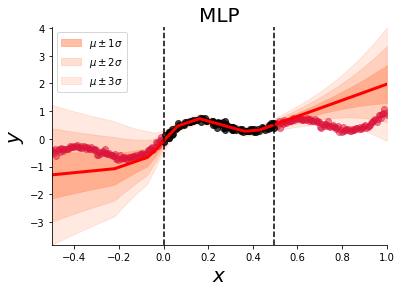

In [50]:
x_linspace = jnp.linspace(-0.5, 1, 300).reshape(-1,1)
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_linspace, True)
gmlp_mean , gmlp_sigma = gmlp_mean.reshape(n_points), gmlp_sigma.reshape(n_points)
plot.plot_prediction_reg(X, y, x_test, y_test, x_linspace, gmlp_mean, gmlp_sigma, 'MLP')

## MC Dropout Gaussian MLP

In [ ]:
n_stacks = 100
fn = lambda i : gmlp_model.apply(gmlp_params, x_linspace, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(fn, in_axes=(0))(jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

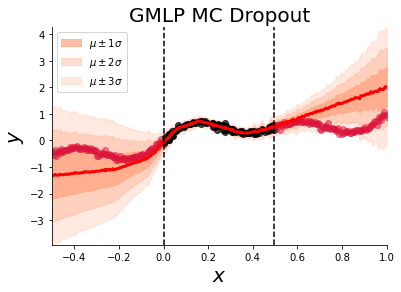

In [ ]:
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)
mc_mean, mc_sigma= mc_mean.reshape(n_points),mc_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout')

In [ ]:
mc_loss_train,mc_loss_test=0,0
for i in range(n_stacks):
    mc_loss_test+=loss_calcc(gmlp_model,gmlp_params,x_test_1,y_test_1,deterministic=False)
    mc_loss_test+=loss_calcc(gmlp_model,gmlp_params,x_test_2,y_test_2,deterministic=False)
    mc_loss_train+=loss_calcc(gmlp_model,gmlp_params,X,y,deterministic=False)
mc_loss_train=mc_loss_train/100
mc_loss_test=mc_loss_test/200
mc_loss_train,mc_loss_test

(DeviceArray(-4.3303204, dtype=float32),
 DeviceArray(-0.60028464, dtype=float32))

## Deep Ensemble Gaussian MLP

In [ ]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [ ]:
params_list = []
losses_list = []
n_models = 5

for i in range(5):
    params = gmlp_model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fit(gmlp_model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)


In [ ]:
de_loss_train,de_loss_test=0,0
for i in range(n_models):
    de_loss_test+=loss_calcc(gmlp_model,params_list[i],x_test_1,y_test_1,deterministic=True)
    de_loss_test+=loss_calcc(gmlp_model,params_list[i],x_test_2,y_test_2,deterministic=True)
    de_loss_train+=loss_calcc(gmlp_model,params_list[i],X,y,deterministic=True)
de_loss_train = de_loss_train/n_models
de_loss_test =de_loss_test/(n_models*2)
de_loss_train,de_loss_test

(DeviceArray(-4.3453374, dtype=float32),
 DeviceArray(-0.8787076, dtype=float32))

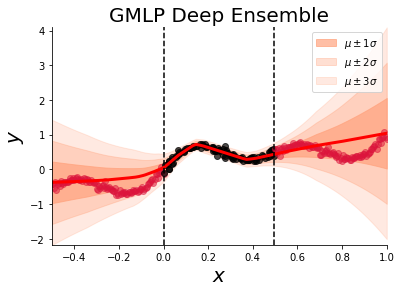

In [ ]:
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_stack)
de_mean, de_sigma = gmm_mean_var(means_list,sigmas_list)
de_mean, de_sigma = de_mean.reshape(n_points),de_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble')

## GP

In [ ]:
key = jax.random.PRNGKey(42)
sigmaf = 1.0
len_scale =  1.0
kernel = GPy.kern.RBF(1, sigmaf, len_scale)
%%capture
model_gp = GPy.models.GPRegression(X, y, kernel, normalizer=False) 
model_gp.Gaussian_noise = 1.0
model_gp.optimize(messages=True)
model_gp.optimize_restarts(num_restarts=5)
%%capture
mu_gp, cov_gp = model_gp.predict(x_stack)
mu_gp=mu_gp.reshape(n_points)
sigma_gp= jnp.sqrt(cov_gp).reshape(n_points)



UsageError: Line magic function `%%capture` not found.


In [ ]:
%%capture
model_gp = GPy.models.GPRegression(X, y, kernel, normalizer=False) 
model_gp.Gaussian_noise = 1.0
model_gp.optimize(messages=True)
model_gp.optimize_restarts(num_restarts=5)

In [ ]:
%%capture
mu_gp, cov_gp = model_gp.predict(x_stack)
mu_gp=mu_gp.reshape(n_points)
sigma_gp= jnp.sqrt(cov_gp).reshape(n_points)

In [ ]:
mu_gp_1, cov_gp_1 = model_gp.predict(X)
mu_gp_2, cov_gp_2= model_gp.predict(x_test_1)
mu_gp_3, cov_gp_3 = model_gp.predict(x_test_2)



In [ ]:
def loss_calcc3(mean,sigma,y):
    def loss_calc(mean, sigma, y):
        d = dist.Normal(loc=mean, scale=sigma)
        return -d.prob(y)
    return jnp.mean(jax.vmap(loss_calc, in_axes=(0, 0, 0))(mean, sigma, y))

In [ ]:
l1 = loss_calcc3(mu_gp_1, jnp.sqrt(cov_gp_1),y)
l2 = (loss_calcc3(mu_gp_2, jnp.sqrt(cov_gp_2),y_test_1)+loss_calcc3(mu_gp_3, jnp.sqrt(cov_gp_3),y_test_2))/2
l1,l2

(DeviceArray(-4.351242, dtype=float32),
 DeviceArray(-0.97070515, dtype=float32))

In [ ]:
model_gp = GPy.models.GPRegression(X, y, kernel, normalizer=False)
gp_train_loss = model_gp.log_likelihood()
gp_train_loss
# model_test = GPy.models.GPRegression(x_test, y_test, kernel, normalizer=False)
# model_test.log_likelihood() (edited) 

DeviceArray(-97.42294, dtype=float32)

In [ ]:
# gmlp_train_loss,gmlp_test_loss= loss_calcc(gmlp_model,gmlp_params,X,y,deterministic=True),jnp.mean(loss_calcc(gmlp_model,gmlp_params,x_test_1,y_test_1,deterministic=True))

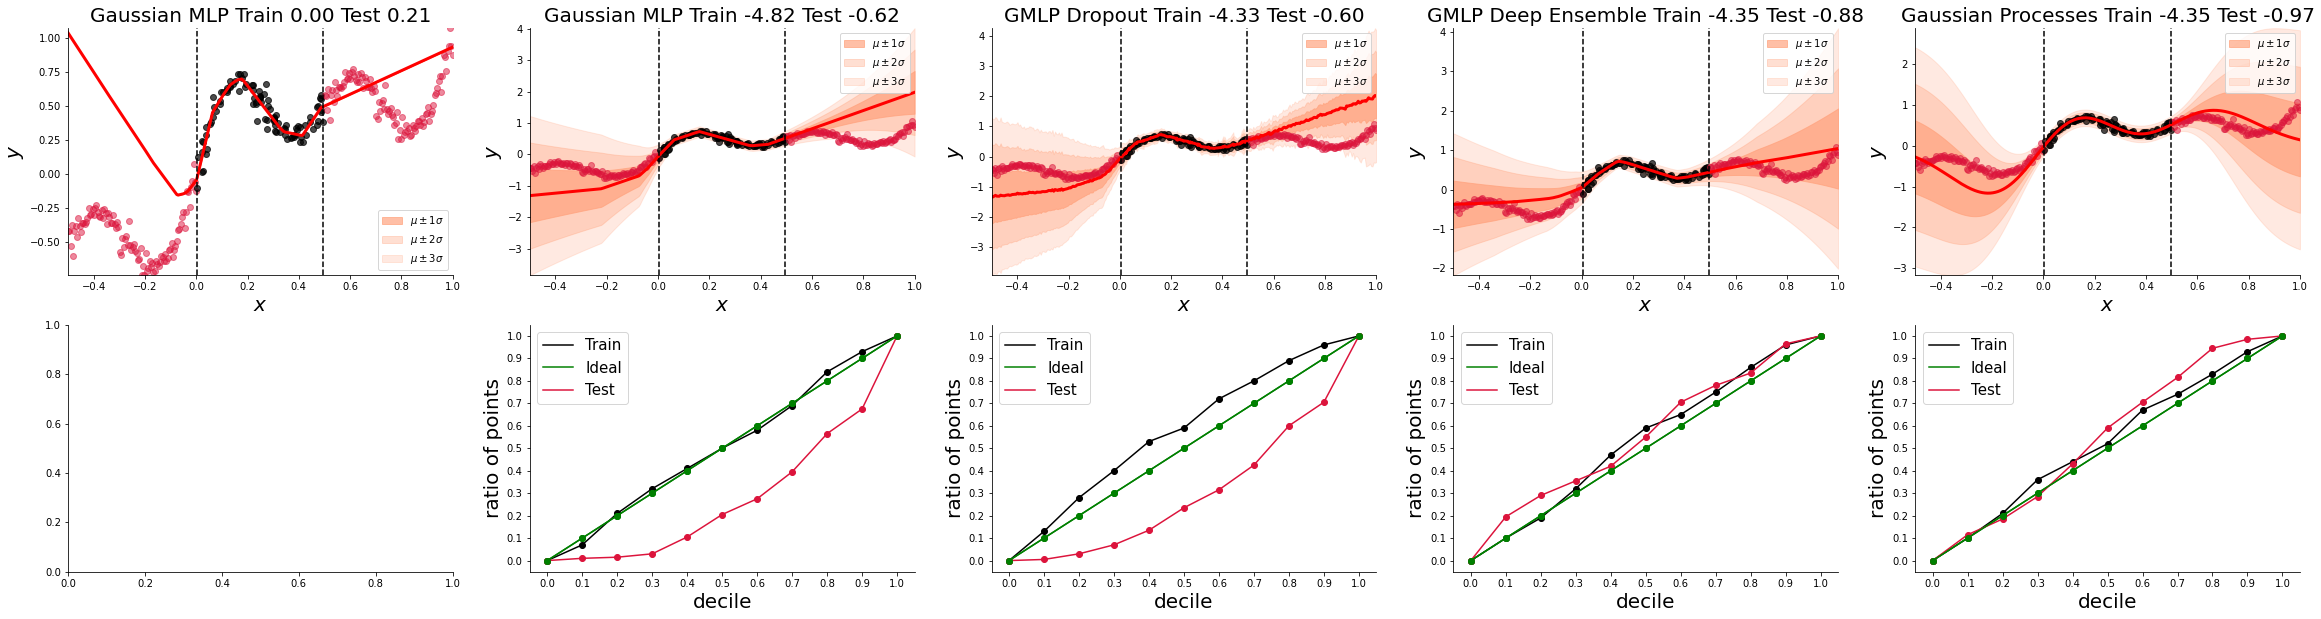

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(40, 10))
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,f'Gaussian MLP Train {mlp_loss_train:.2f} Test {mlp_loss_test:.2f}',ax[0][0])
plot.plot_prediction(X,y,x_stack,y_stack,gmlp_mean,gmlp_sigma,f'Gaussian MLP Train {gmlp_train_loss:.2f} Test {gmlp_test_loss:.2f}',ax[0][1])
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,f'GMLP Dropout Train {mc_loss_train:.2f} Test {mc_loss_test:.2f}',ax[0][2])
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,f'GMLP Deep Ensemble Train {de_loss_train:.2f} Test {de_loss_test:.2f}',ax[0][3])
plot.plot_prediction(X,y,x_stack,y_stack,mu_gp,sigma_gp,f'Gaussian Processes Train {l1:.2f} Test {l2:.2f}',ax[0][4])
# plot.calibration_reg(y_hat,jnp.zeros(300),y_stack,ax[1][0])
plot.calibration_reg(gmlp_mean,gmlp_sigma,y_stack,ax[1][1])
plot.calibration_reg(mc_mean,mc_sigma,y_stack,ax[1][2])
plot.calibration_reg(de_mean,de_sigma,y_stack,ax[1][3])
plot.calibration_reg(mu_gp,sigma_gp,y_stack,ax[1][4])
plt.savefig('SinData.pdf')

